The code replicates the Vision Tranfomer Paper named:

**An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**

https://arxiv.org/abs/2010.11929

In [1]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets

from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional, Union

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves



Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!
[INFO] Predicting on None


In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
image_url = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi.zip"

dest = "pizza_steak_sushi"

if os.path.exists(dest):
  print(f"\u2705 {dest} already exists...skipping")
else:
  print(f"{icons.INFO} {dest} does not exists..adding")
  image_path = download_data(image_url, dest)

ℹ️ pizza_steak_sushi does not exists..adding
ℹ️ Did not find data/pizza_steak_sushi directory, creating one...
ℹ️ Downloading pizza_steak_sushi.zip from https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi.zip...
ℹ️ Unzipping pizza_steak_sushi.zip data...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create DataLoaders

In [5]:
# Transform the data
IMAGE_SIZE = (224,224)
transforms = v2.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [6]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    device=device
)

# Visualize a random sample image from train dataloader

In [7]:
# Random select an image from the train dataloader
image_batch, label_batch = next(iter(train_dataloader))

idx_to_select = random.choice(torch.arange(len(image_batch)))

image, label = image_batch[idx_to_select],  label_batch[idx_to_select]

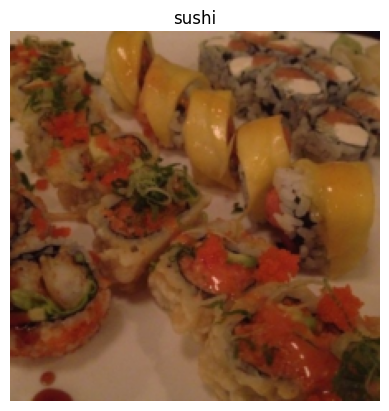

In [8]:
# Display the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

# Visualize the image into patches each of size 16x16

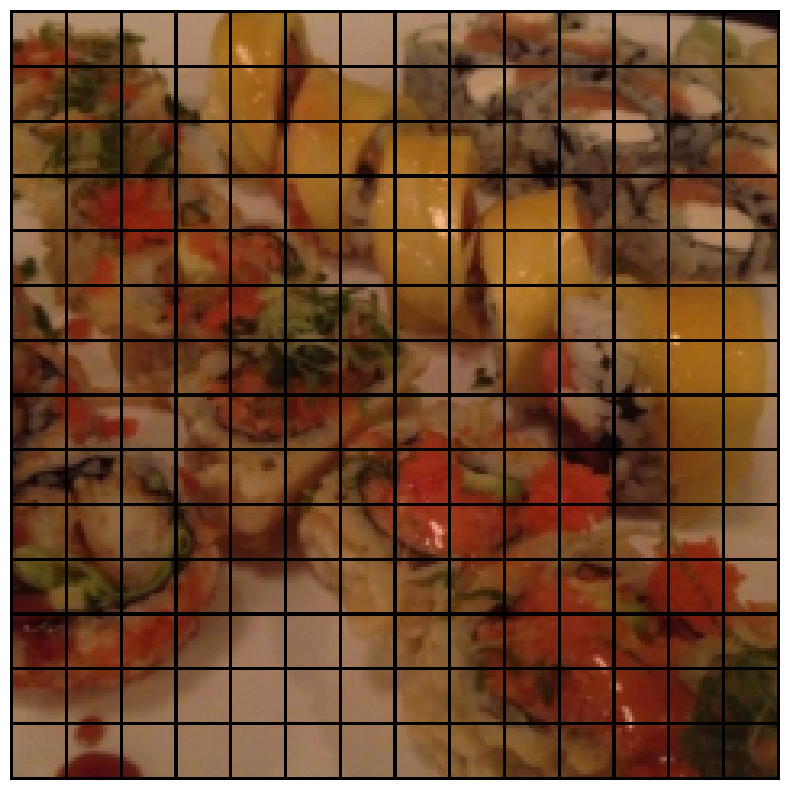

In [9]:
# Faster way using PyTorch unfold and make_grid function
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

ps = 16
x = image.unsqueeze(0) # Add a batch dimension

# Get height and width from the image tensor
B, C, H, W = x.shape

patches = torch.nn.functional.unfold(x, kernel_size=ps, stride=ps)  # (1, 3*ps*ps, N)

B, _, N = patches.shape
patches = patches.view(B, C, ps, ps, N).permute(0,4,1,2,3).reshape(N, C, ps, ps)  # (N,3,ps,ps)

grid = make_grid(patches, nrow=W//ps, padding=1)  # padding draws 1px gaps
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu().numpy(), interpolation="nearest")
plt.axis("off")
plt.tight_layout()
plt.show()

# Define a class to create the patch embeddings

In [10]:
class PatchEmbedding(nn.Module):
  """
  Creates a patch embedding layer
  Arguments:
  in_channel: int = number of input channels, provided by image.shape[0]
  path_size: int = size of the patch
  embedding_dim: int = number of embedding dimensions
  img: Optional[torch.Tensor] = image tensor, default: None
  use_cls_token: bool = whether to use a cls token, default: True
  Attributes:
  patch_size: int = size of the patch
  use_cls_token: bool = whether to use a cls token
  pos_embed: nn.Parameter = positional embedding
  conv2dproj: nn.Conv2d = convolution layer
  Output:
  x: torch.Tensor = patch embeddings
  """
  def __init__(self,
                in_channels: int,
                patch_size: int,
                embedding_dim: int,
                img: Optional[torch.Tensor] = None,
                use_cls_token: bool = True):
      super().__init__()
      self.patch_size = patch_size
      self.use_cls_token = use_cls_token

      self.conv2dproj = nn.Conv2d(in_channels,
                                  embedding_dim,
                                  kernel_size=patch_size,
                                  stride=patch_size,
                                  padding=0,
                                  bias=True)

      self.cls_token = nn.Parameter(torch.ones(1, 1, embedding_dim)) if use_cls_token else None
      if self.cls_token is not None:
          nn.init.trunc_normal_(self.cls_token, mean=0, std=0.02)

      if img is not None:
          _, H, W = img.shape
          assert H % patch_size == 0 and W % patch_size == 0, \
              f"img_size must be divisible by patch_size (got H={H}, W={W}, P={patch_size})"
          n_patches = (H // patch_size) * (W // patch_size)
          n_tokens = n_patches + (1 if use_cls_token else 0)
          self.pos_embed = nn.Parameter(torch.ones(1, n_tokens, embedding_dim))
          nn.init.trunc_normal_(self.pos_embed, mean=0, std=0.02)
      else:
          self.pos_embed = None  # create or resize on forward

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = x.float()  # avoid Byte dtype issues
      B, C, H, W = x.shape
      p = self.patch_size
      assert H % p == 0 and W % p == 0, f"H={H}, W={W} must be divisible by patch_size={p}"

      # (B, E, H/P, W/P) -> (B, N, E)
      x = self.conv2dproj(x).flatten(2).transpose(1, 2)

      if self.use_cls_token:
          cls = self.cls_token.expand(B, -1, -1)    # (B, 1, E)
          x = torch.cat([cls, x], dim=1)            # (B, N+1, E)

      # Positional embeddings
      if self.pos_embed is None:
          # first-time lazy init to current length
          self.pos_embed = nn.Parameter(torch.ones(1, x.shape[1], x.shape[2], device=x.device, dtype=x.dtype))
          nn.init.trunc_normal_(self.pos_embed, mean=0, std=0.02)
      elif self.pos_embed.shape[1] != x.shape[1]:
          # safer behavior: interpolate or raise (choose one)
          raise ValueError(
              f"pos_embed length {self.pos_embed.shape[1]} != tokens {x.shape[1]} — "
              f"provide matching img_size or add interpolation."
          )

      return x + self.pos_embed  # (B, N(+1), E)


In [11]:
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=16,
                          img=image)
image_patched_flattened = patchify(image.unsqueeze(0))

In [12]:
image_patched_flattened, image_patched_flattened.shape

(tensor([[[ 0.0197,  0.0240,  0.0269,  ...,  0.0386, -0.0510,  0.0013],
          [-0.2696, -0.2793,  0.0967,  ...,  0.3235,  0.2862,  0.0593],
          [-0.2927, -0.2230,  0.1437,  ...,  0.3499,  0.3480,  0.0554],
          ...,
          [-0.1407, -0.1684, -0.0043,  ...,  0.1914,  0.2310,  0.0973],
          [-0.0933, -0.1579,  0.0810,  ...,  0.1585,  0.1685,  0.0232],
          [-0.1387, -0.0904,  0.0019,  ...,  0.1354,  0.0760,  0.0160]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

# Create a Multi-Head Self Attention Block (MSA)

In [13]:
class MultiHeadAttentionBlock(nn.Module):
    """
    Pre-norm multi-head *self*-attention block.

    Args:
        embedding_dim: Model/embedding dimension (E).
        num_heads: Number of attention heads (H). Must divide embedding_dim.
        dropout_p: Dropout probability applied to the attention output proj.
        batch_first: Inputs are (B, S, E) if True else (S, B, E).

    Inputs:
        x: Float tensor of shape (B, S, E) if batch_first else (S, B, E).
        attn_mask: Optional causal or custom mask of shape (S, S) or broadcastable.
        key_padding_mask: Optional bool of shape (B, S); True marks pads to ignore.
        need_weights: If True, returns average attention weights.

    Returns:
        y or (y, attn) where y has same shape as x.
    """
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        dropout_p: float = 0.0,
        batch_first: bool = True,
        eps: float = 1e-5,
    ):
        super().__init__()
        assert embedding_dim % num_heads == 0, \
            f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads})"

        self.batch_first = batch_first
        self.ln = nn.LayerNorm(embedding_dim, eps=eps)

        self.attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_p,          # attention-prob dropout
            batch_first=batch_first,
            bias=True
        )
        self.dropout = nn.Dropout(dropout_p)  # output-proj dropout

    def forward(
        self,
        x: torch.Tensor,
        *,
        attn_mask: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        average_attn_weights: bool = True,
    ) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor]:

        residual = x
        x = self.ln(x)

        x, attn = self.attn(
            query=x, key=x, value=x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights
        )

        x = self.dropout(x)
        x = residual + x  # residual connection

        return (x, attn) if need_weights else x


In [14]:
msa = MultiHeadAttentionBlock(embedding_dim=768,
                               num_heads=12)
msa_output = msa(image_patched_flattened)

In [15]:
msa_output, msa_output.shape
#

(tensor([[[ 0.2848,  0.4697, -0.2980,  ...,  0.6092, -0.0432,  0.2321],
          [-0.0023,  0.1651, -0.2288,  ...,  0.8822,  0.3055,  0.2759],
          [-0.0271,  0.2190, -0.1820,  ...,  0.9097,  0.3657,  0.2721],
          ...,
          [ 0.1278,  0.2752, -0.3316,  ...,  0.7529,  0.2525,  0.3095],
          [ 0.1751,  0.2830, -0.2455,  ...,  0.7231,  0.1889,  0.2372],
          [ 0.1262,  0.3546, -0.3248,  ...,  0.6965,  0.0929,  0.2314]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [16]:
image_patched_flattened

tensor([[[ 0.0197,  0.0240,  0.0269,  ...,  0.0386, -0.0510,  0.0013],
         [-0.2696, -0.2793,  0.0967,  ...,  0.3235,  0.2862,  0.0593],
         [-0.2927, -0.2230,  0.1437,  ...,  0.3499,  0.3480,  0.0554],
         ...,
         [-0.1407, -0.1684, -0.0043,  ...,  0.1914,  0.2310,  0.0973],
         [-0.0933, -0.1579,  0.0810,  ...,  0.1585,  0.1685,  0.0232],
         [-0.1387, -0.0904,  0.0019,  ...,  0.1354,  0.0760,  0.0160]]],
       grad_fn=<AddBackward0>)

# Create MultiLayer Perceptron Block

In [17]:
import torch
from torch import nn

class MLPBlock(nn.Module):
    """
    Pre-norm feed-forward (MLP) block used in Transformer/ViT.

    Args:
        embedding_dim: Model/embedding dimension (E).
        mlp_size: Hidden size of the MLP. If None, defaults to mlp_ratio * E.
        mlp_ratio: Expansion ratio to compute mlp_size when mlp_size is None.
        dropout_p: Dropout probability applied within the MLP.
        eps: Epsilon for LayerNorm.
        activation: Activation module class (default: nn.GELU).
        drop_path: Stochastic depth prob (0.0 disables).

    Input:
        x: (B, S, E)

    Returns:
        y: (B, S, E)
    """
    def __init__(self,
                 embedding_dim: int,
                 mlp_size: int | None = None,
                 mlp_ratio: float = 4.0,
                 dropout_p: float = 0.1,
                 eps: float = 1e-5,
                 activation: type[nn.Module] = nn.GELU):
        super().__init__()
        hidden = mlp_size if mlp_size is not None else int(mlp_ratio * embedding_dim)

        self.ln = nn.LayerNorm(embedding_dim, eps=eps)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden),
            activation(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden, embedding_dim),
            nn.Dropout(dropout_p),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln(x)
        x = self.mlp(x)
        return residual + x

In [ ]:
mlp = MLPBlock(embedding_dim=768)
mlp_output = mlp(msa_output)